<a href="https://colab.research.google.com/github/prashants975/Projects_on_ML/blob/master/Housing_Price_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Housing Price Prediction </h1>
<ul>
<li> Data Taken From <a href= 'https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv'> Handson Ed2 </a></li>
<li>Linear Regression Problem on Predicting the housing prices</li>
</ul>

In [7]:
from google.colab import files
uploaded = files.upload()

Saving housing.csv to housing.csv


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [9]:
#reading the data in dataframe
df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [10]:
#info of all the rows and columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [11]:
df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

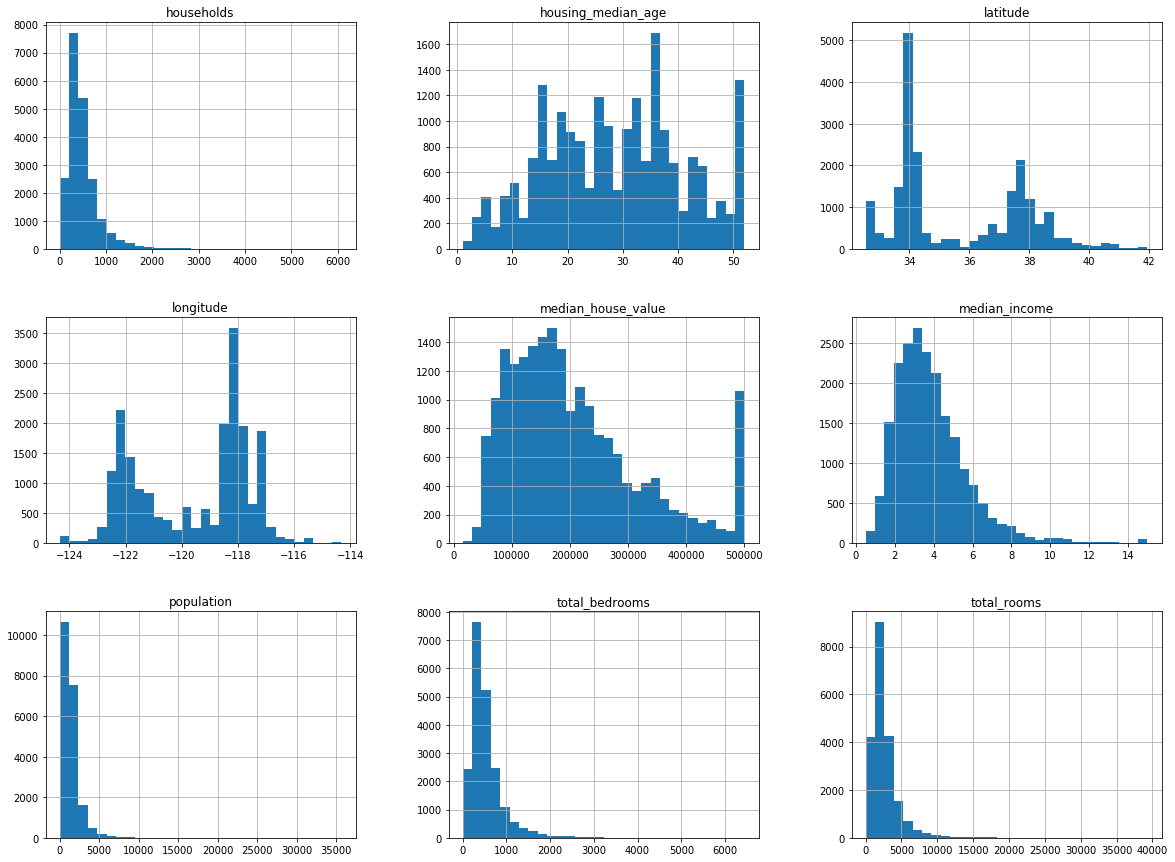

In [12]:
%matplotlib inline
df.hist(bins = 30, figsize = (20,15))
plt.show()

In [0]:
#creating test and train set with 0.8/0.2 rule
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

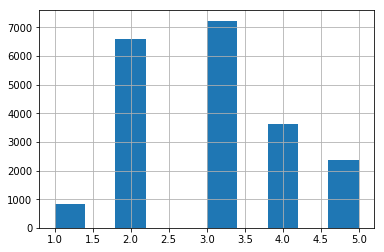

In [14]:
#dividing the median_income in 5 categories to avoid bias of median_income in test and train set
df['income_category'] = pd.cut(df['median_income'], bins = [0.0, 1.5, 3.0, 4.5, 6.0, np.inf], labels = [1, 2, 3, 4, 5])
df['income_category'].hist()

In [15]:
#stratified sampling to avoid bias on income category
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(df, df["income_category"]):
    strat_train_set = df.loc[train_idx]
    strat_test_set = df.loc[test_idx]
    
#check the proportion of test and train set
prop_test = strat_test_set["income_category"].value_counts() / len(strat_test_set)
prop_train = strat_train_set["income_category"].value_counts() / len(strat_train_set)
print(prop_test)
print(prop_train)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_category, dtype: float64
3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_category, dtype: float64


In [0]:
for set in (strat_train_set, strat_test_set):
    set.drop('income_category', axis = 1, inplace = True)

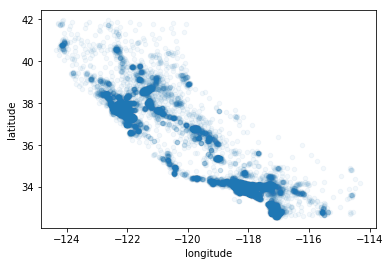

In [17]:
#visualizing the data by lattitude and longitude
df.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.05)
#density of the location can be observed from below graph

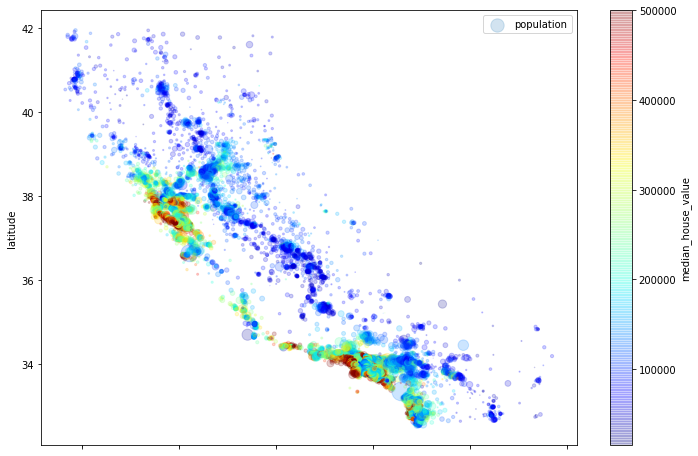

In [18]:
#more informative visulatzation with size of marker depicting population and color for house values
df.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.2, s = df['population']/100, label = 'population',
       figsize = (12,8), c = 'median_house_value', cmap = plt.get_cmap('jet'), colorbar = True)
plt.legend()
#one can infer that prices are related 

In [19]:
#checking the correlation of all the attritubes with median_house_value
corr_matrix = df.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3c23a1acc0>,
      dtype=object)

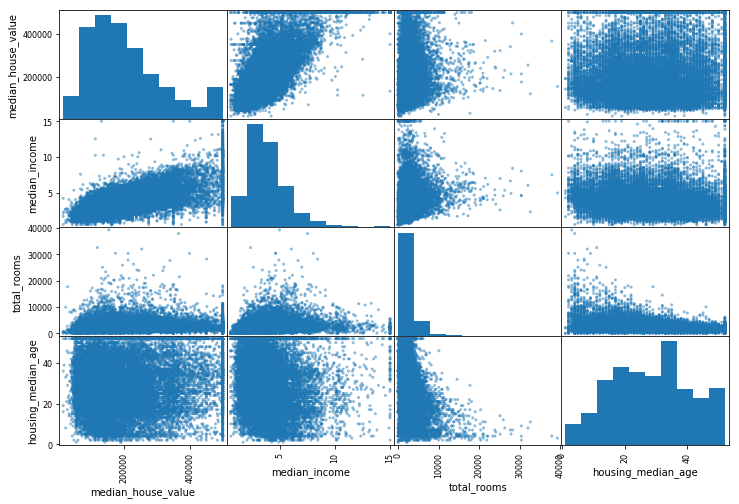

In [20]:
#plotting scatter_matrix to understand the correlation 
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms","housing_median_age"]
scatter_matrix(df[attributes], figsize=(12, 8))

In [0]:
#preparing data by filling the missing values and using oneHotencoder for categorical values
housing  =  strat_train_set.drop('median_house_value', axis = 1)
housing_labels = strat_train_set['median_house_value'].copy()
housing_num = housing.drop('ocean_proximity', axis = 1)
housing_cat = housing[['ocean_proximity']]

In [0]:
from sklearn.impute  import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [0]:
num_pipeline = Pipeline([
('imputer', SimpleImputer(strategy="median")),
('attribs_adder', CombinedAttributesAdder()),
('std_scaler', StandardScaler()),
])

In [0]:
from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
("num", num_pipeline, num_attribs),
("cat", OneHotEncoder(), cat_attribs),
])

In [31]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [32]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [33]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]
